In [15]:
# to use cd, etc
import sys
import os

import numpy as np
# for math work
from numpy import linalg, matlib
# save, import and load data
from numpy import asarray, save, load

# needed for some matrix manipulations
import cvxpy as cp
# import math 

import scipy
# for curve fitting
from scipy import optimize
from scipy.io import loadmat  # this is the SciPy module that loads mat-files

from sklearn.metrics import r2_score, mean_squared_error

import mat73
import pandas as pd

import matplotlib.pyplot as plt
# for plots
import seaborn
# set up seaborn for the plots
seaborn.set()

# suppress deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# # to save data plots
from matplotlib.backends.backend_pdf import PdfPages

import pickle

In [16]:
date = '2021_07_26/'
path = '/Users/mmadduri/Documents/PhD/ResearchMaterials/Code/BMI_Model/data/' + date
file = 'kinData.pkl'

with open(path + file , 'rb') as infile:
    y_, ypred, K_, targs, ylast = pickle.load(infile)

In [17]:
K_.shape

(40, 380, 9)

In [13]:
def sg(c,u,N,D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )

  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.randn(N,u.size)
  #d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D
  d.reshape(tuple([N]+list(u.shape)))
  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    Dc[n] = (c(u+d[n]) - c(u-d[n])) * d[n] 
  Dc /= 2*D**2
  return Dc


def gd(c,u0,Dc,g,I):
  """
  gradient descent
  for i in I:
    u -= g(u)*Dc(u)

  inputs:
    c : U -> R
    u0 in U - decision variable in vector space U
    g(u,i) > 0 - step size
    I - int - number of iterations

  outputs:
    U in I x U
  """
  U = np.nan*np.zeros((I,u0.size))
  U.reshape(tuple([I]+list(u0.shape)))
  U[0] = u0
  for i in range(I-1):
    U[i+1] = U[i] - g(U[i],i) * Dc(U[i])
  return U

def PSD(n,sqrt=False):
  """
  compute random positive semidefinite matrix

  input:
    n - int - dimension of matrix
    (optional)
    sqrt - bool - whether to return S such that Q = np.dot( S.T, S)

  output:
    Q - n x n - Q = Q^T,  spec Q \subset [0,oo)
  """
  H = np.random.randn( n, n )
  d,u = np.linalg.eig( H + H.T )
  d *= np.sqrt(np.arange(d.size)+.1)
  S = np.dot( u, np.dot( np.diag( np.sqrt( d*np.sign( d ) ) ), u.T ) )
  Q = np.dot( S.T, S )
  if sqrt:
    return Q, S
  else:
    return Q

In [63]:
N = 100 #number of displacements
D = 1e-3 #size of displacements
lamba_k = .01

# u is each K
# output is a scalar
ck = lambda e, u : np.linalg.norm(e, 2)**2 + lamba_k*np.linalg.norm(u, 2)**2  

In [64]:
np.mean(K_)

-1.5138253021723935e-05

### Running the stochastic gradient descent

July 21 2021
- at I = 5, took about 4+ minutes to run a batch of 200 trials 
- what we're noticing, the r^2 is really bad -- not much predictive capability, even when you separate by neuron and do sgd neuron to neuron
- maybe try by target
- K doesn't seem to be changing much with the SGD --> $r^2$ was really good when we compared k_pred[n+1] with k_actual[n]

In [65]:
# Dc = lambda u : sg(c,u,N,D).mean(axis=0)
# g = lambda u,i : 10#/(i+1)


U_ = []
cU_ = []

# numNeurons = K_.shape[1]
st = K_.shape[0] # number of states
nt = K_.shape[1] # number of neurons
dt = K_.shape[2] # number of decoder

g_g = lambda u,i : 10 #exploration parameter

ck_ = lambda u: ck(ylast-targs[:, 0:2], u)
Dck = lambda u: sg(ck_,u,N,D).mean() # derivative

ckx_ = lambda u: ck(ylast[:, 0]-targs[:, 0], u)
cky_ = lambda u: ck(ylast[:, 1]-targs[:, 1], u)
# ck_ = lambda u: ck(ylast[0]-targs[0], u)
Dckx = lambda u: sg(ckx_,u,N,D).mean() # derivative
Dcky = lambda u: sg(cky_,u,N,D).mean() # derivative

# bStart = 5000
# bEnd = 5500
# tList = np.where(targs[:, 2] == 1)[0]

# batch = np.arange(bStart, bEnd, 1)

I = 25 # number of gradient descents

# Knext_x = np.zeros((numNeurons, len(batch)))
# Knext_y = np.zeros((numNeurons, len(batch)))

Knext = []
for iD in range(dt):
    Knext.append(gd(ck_, np.ndarray.flatten(K_[:, :, iD]), Dck, g_g, 40)[-1])
    
    
    
#         Ksolve_ = gd(ckx_,K_[0,iN, iB],Dckx,g_g, I)[-1]
#         Knext_x[iN, iB-bStart] = Ksolve_x
        
        
        
#     Ksolve_y = gd(cky_,K_[1,:, ii],Dcky,g_g, 2)[-1]
#     Ksolve = gd(ck_,np.ndarray.flatten(K_[:,:, ii]),Dck,g_g, 2)[-1] # -1 becuase it comes out as a [2, xx] array and you need the last step
#     print(np.array(Ksolve).shape)
#     Knext_x.append(Ksolve_x)  
#     Knext_y.append(Ksolve_y)
#     mse.append(mean_squared_error(Ksolve, np.ndarray.flatten(K_[:, :, ii+1])))
#     print(mse[-1])

In [66]:
Kpred = np.array(Knext)
Kpred.shape

(9, 15200)

In [67]:
K_.shape

(40, 380, 9)

In [68]:
# Kactual = K_.reshape(int(st*nt),int(dt)).T
Kactual = np.zeros_like(Kpred)
for iD in range(dt):
    Kactual[iD] = np.ndarray.flatten(K_[:, :, iD])

Kactual.shape

(9, 15200)

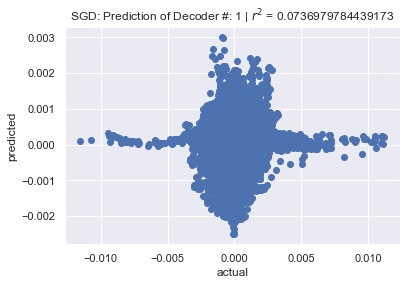

0.03578827349956841 2.3356797026027406e-05 0.0736979784439173 9.224559334919346e-20 0.003928342322914649


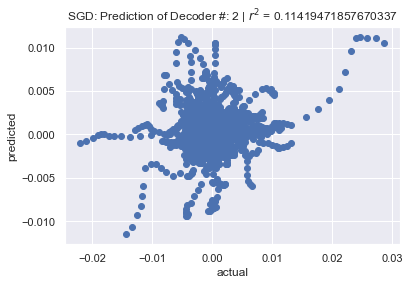

0.07894927518297055 8.59090206930123e-05 0.11419471857670337 2.7045852927074706e-45 0.005571326224552458


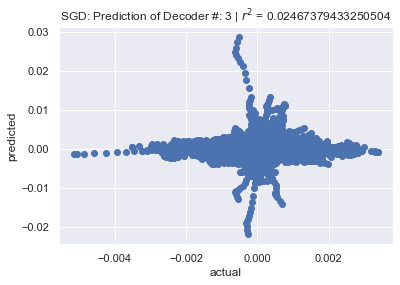

0.06464199115020018 5.351515877621721e-05 0.02467379433250504 0.002348537654276211 0.021244833232578735


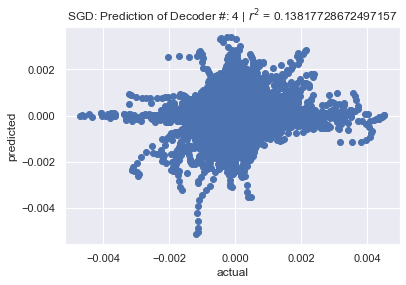

0.12680300999456248 -1.3479452975675653e-05 0.13817728672497157 1.1199075646326133e-65 0.007372480071837261


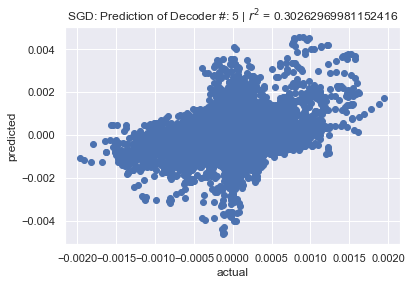

0.5308867725617623 3.533512224984969e-05 0.30262969981152416 0.0 0.01356248744807245


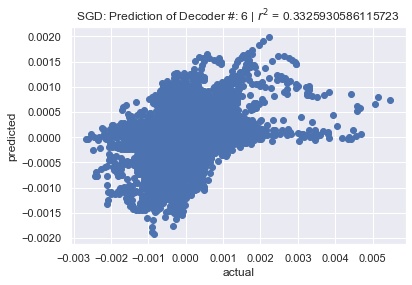

0.23651034810695462 1.816300249669741e-05 0.3325930586115723 0.0 0.005439861957924159


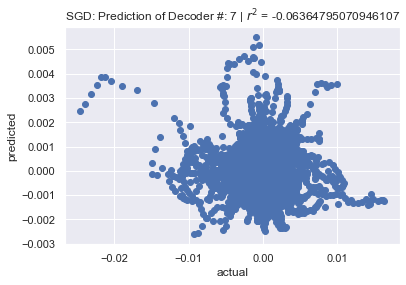

-0.018249885207976886 1.6339120043562907e-05 -0.06364795070946107 4.018021928631669e-15 0.0023211383569806308


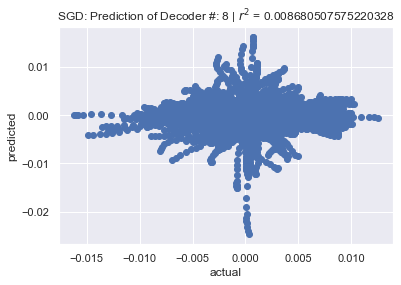

0.007054891161918572 -0.00014519525313543715 0.008680507575220328 0.2845576490695869 0.0065922795361632175


In [69]:
for iN in range(dt-1):
    slope, intercept, r, p, se = scipy.stats.linregress(Kactual[iN + 1], Kpred[iN])
    plt.scatter(Kactual[iN + 1], Kpred[iN])

    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title("SGD: Prediction of Decoder #: " + str(iN + 1) +  " | $r^2$ = " + str(r))
    plt.show()
    print(slope, intercept, r, p, se)
